Annotation info:
Image size: {'height': 2909, 'width': 1642}
Number of objects: 1
Decompressed data length: 29561
Origin: [421, 474]
Bitmap shape: (1388, 712)
Bitmap unique values: [  0 255]

Final mask shape: (2909, 1642)
Final mask unique values: [  0 255]
Non-zero pixels: 637924


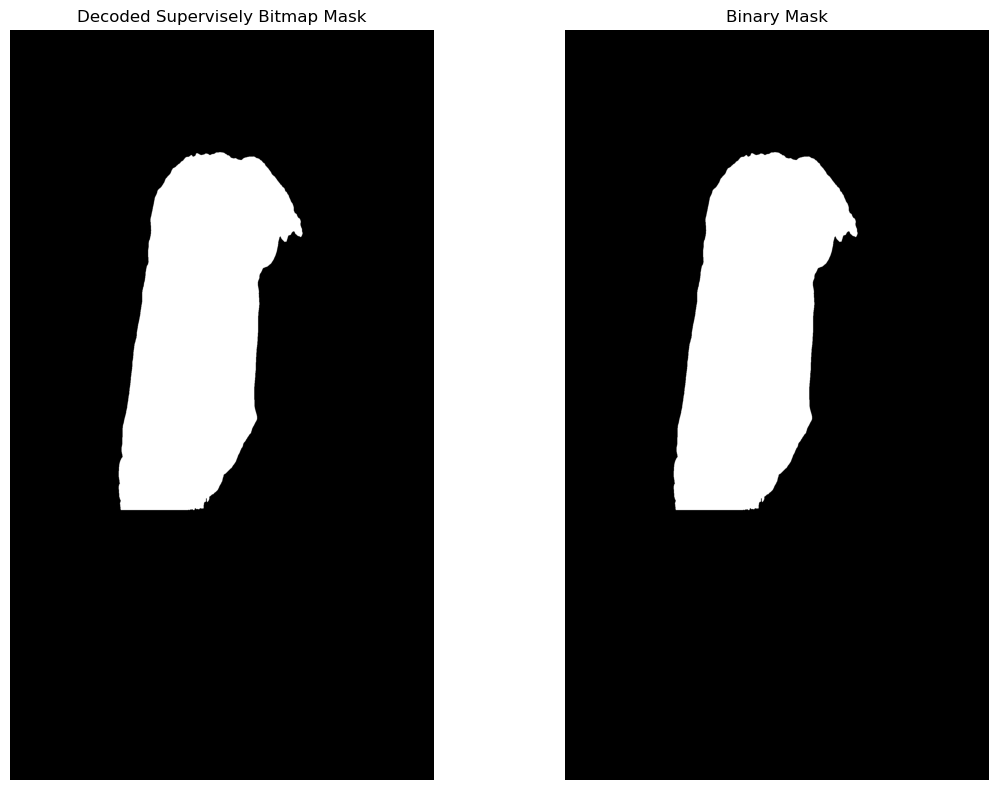

In [6]:
import json
import base64
import zlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import io

def decode_supervisely_bitmap_proper(annotation_data):
    """
    Properly decode Supervisely bitmap mask from annotation data
    Supervisely stores bitmap data as compressed PNG-like format
    """
    img_height = annotation_data['size']['height']
    img_width = annotation_data['size']['width']
    
    # Create empty mask
    full_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    
    for obj in annotation_data.get('objects', []):
        if obj.get('geometryType') == 'bitmap' and 'bitmap' in obj:
            bitmap_data = obj['bitmap']
            
            # Get the encoded bitmap data and origin
            encoded_data = bitmap_data['data']
            origin = bitmap_data['origin']  # [x, y] coordinates
            
            try:
                # Decode base64 and decompress
                compressed_data = base64.b64decode(encoded_data)
                decompressed_data = zlib.decompress(compressed_data)
                
                print(f"Decompressed data length: {len(decompressed_data)}")
                print(f"Origin: {origin}")
                
                # Supervisely bitmap data is typically stored as PNG-like format
                # Try to decode as image data first
                try:
                    # Try to load as image bytes
                    img_bytes = io.BytesIO(decompressed_data)
                    bitmap_img = Image.open(img_bytes)
                    bitmap_array = np.array(bitmap_img)
                    
                    # Convert to binary mask if needed
                    if len(bitmap_array.shape) > 2:
                        # Convert to grayscale if RGB
                        bitmap_array = np.mean(bitmap_array, axis=2)
                    
                    # Normalize to 0-255
                    bitmap_array = (bitmap_array > 0).astype(np.uint8) * 255
                    
                except:
                    # If that fails, try other decoding methods
                    # Supervisely sometimes stores data as raw bytes with width/height info
                    
                    # Try to find dimensions from the remaining space
                    remaining_width = img_width - origin[0]
                    remaining_height = img_height - origin[1]
                    
                    # Check if it's a simple bitmap (1 bit per pixel, packed)
                    expected_bits = remaining_width * remaining_height
                    expected_bytes = (expected_bits + 7) // 8  # Round up to nearest byte
                    
                    if len(decompressed_data) == expected_bytes:
                        # Unpack bits
                        bits = np.unpackbits(np.frombuffer(decompressed_data, dtype=np.uint8))
                        bitmap_array = bits[:expected_bits].reshape((remaining_height, remaining_width)) * 255
                    else:
                        # Try interpreting as bytes directly
                        mask_1d = np.frombuffer(decompressed_data, dtype=np.uint8)
                        
                        # Find best fitting dimensions
                        possible_dims = []
                        for w in range(1, min(remaining_width + 1, len(mask_1d) + 1)):
                            if len(mask_1d) % w == 0:
                                h = len(mask_1d) // w
                                if h <= remaining_height and w <= remaining_width:
                                    possible_dims.append((h, w))
                        
                        if possible_dims:
                            # Choose the most square-like dimensions
                            h, w = min(possible_dims, key=lambda x: abs(x[0] - x[1]))
                            bitmap_array = mask_1d.reshape((h, w))
                            # Threshold to binary
                            bitmap_array = (bitmap_array > 0).astype(np.uint8) * 255
                        else:
                            print(f"Could not determine bitmap dimensions")
                            continue
                
                print(f"Bitmap shape: {bitmap_array.shape}")
                print(f"Bitmap unique values: {np.unique(bitmap_array)}")
                
                # Place the bitmap in the full mask
                end_y = min(origin[1] + bitmap_array.shape[0], img_height)
                end_x = min(origin[0] + bitmap_array.shape[1], img_width)
                
                actual_h = end_y - origin[1]
                actual_w = end_x - origin[0]
                
                # Resize bitmap if necessary
                if bitmap_array.shape != (actual_h, actual_w):
                    bitmap_pil = Image.fromarray(bitmap_array)
                    bitmap_pil = bitmap_pil.resize((actual_w, actual_h), Image.NEAREST)
                    bitmap_array = np.array(bitmap_pil)
                
                full_mask[origin[1]:end_y, origin[0]:end_x] = bitmap_array
                
            except Exception as e:
                print(f"Error decoding bitmap: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    return full_mask

# Load and decode the annotation
json_path = r"supervisely/dataset/ann/blackpig1crop.jpg.json"
with open(json_path, 'r') as f:
    annotation_data = json.load(f)

print("Annotation info:")
print(f"Image size: {annotation_data['size']}")
print(f"Number of objects: {len(annotation_data.get('objects', []))}")

# Decode the bitmap mask
mask = decode_supervisely_bitmap_proper(annotation_data)

print(f"\nFinal mask shape: {mask.shape}")
print(f"Final mask unique values: {np.unique(mask)}")
print(f"Non-zero pixels: {np.sum(mask > 0)}")

# Visualize the mask
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Decoded Supervisely Bitmap Mask')
plt.axis('off')

# Show mask as binary
plt.subplot(1, 2, 2)
binary_mask = (mask > 0).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

Image size: (1642, 2909)
Mask shape: (2909, 1642)
Masked image saved as: masked_pig_supervisely.png


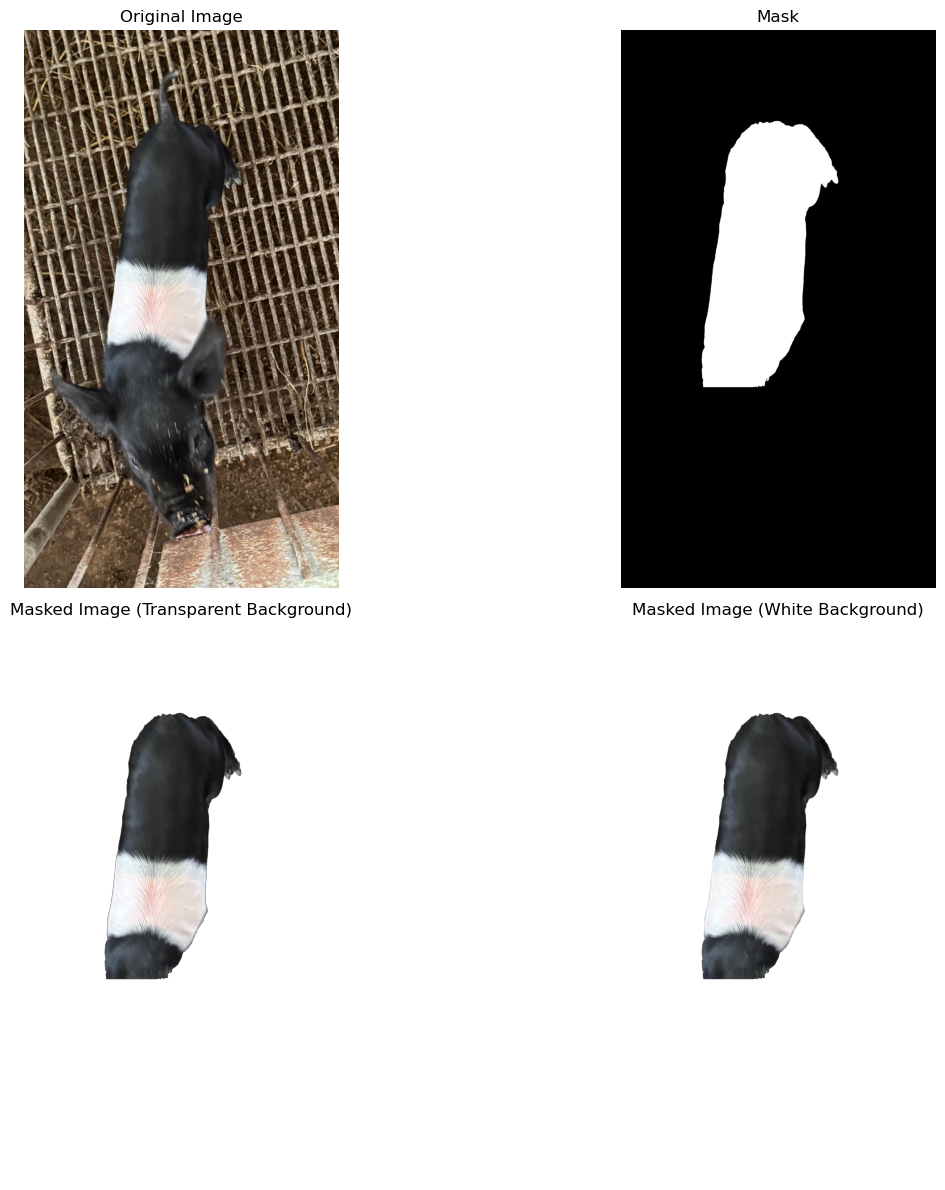

Also saved version with white background as: masked_pig_supervisely_white_bg.jpg


In [7]:
# Apply the mask to the original image
from PIL import Image
import matplotlib.pyplot as plt

# Load the original image
image_path = r"supervisely/dataset/img/blackpig1crop.jpg"
image = Image.open(image_path).convert("RGBA")

print(f"Image size: {image.size}")
print(f"Mask shape: {mask.shape}")

# Convert mask to PIL Image
mask_pil = Image.fromarray(mask, mode='L')

# Resize mask if needed to match image size
if mask_pil.size != image.size:
    # The mask is typically larger, so we need to resize the image or mask
    # Let's resize the image to match the mask size for better quality
    image = image.resize((mask.shape[1], mask.shape[0]), Image.LANCZOS)
    print(f"Resized image to match mask: {image.size}")

# Apply mask to create masked image
# Create transparent background
transparent_bg = Image.new("RGBA", image.size, (0, 0, 0, 0))
masked_image = Image.composite(image, transparent_bg, mask_pil)

# Save the result
output_path = "masked_pig_supervisely.png"
masked_image.save(output_path)
print(f"Masked image saved as: {output_path}")

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original image
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Mask
axes[0, 1].imshow(mask_pil, cmap='gray')
axes[0, 1].set_title('Mask')
axes[0, 1].axis('off')

# Masked image
axes[1, 0].imshow(masked_image)
axes[1, 0].set_title('Masked Image (Transparent Background)')
axes[1, 0].axis('off')

# Also create a version with white background for better visibility
white_bg = Image.new("RGB", masked_image.size, (255, 255, 255))
white_bg.paste(masked_image, mask=masked_image.split()[-1])
white_bg.save("masked_pig_supervisely_white_bg.jpg")

axes[1, 1].imshow(white_bg)
axes[1, 1].set_title('Masked Image (White Background)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Also saved version with white background as: masked_pig_supervisely_white_bg.jpg")

Pig length (pixels): 1438.66
Width near top: 588.73
Width near bottom: 453.20


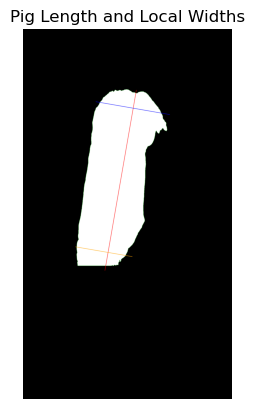

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Find largest contour
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pig_contour = max(contours, key=cv2.contourArea)
points = pig_contour.reshape(-1, 2).astype(np.float32)

# PCA
mean, eigenvectors = cv2.PCACompute(points, mean=np.array([]))
center = mean[0]
axis = eigenvectors[0] / np.linalg.norm(eigenvectors[0])  # main axis
axis2 = eigenvectors[1] / np.linalg.norm(eigenvectors[1])  # perpendicular axis

# Project points onto main axis to get endpoints
proj = (points - center) @ axis
min_proj = proj.min()
max_proj = proj.max()
p1 = center + axis * min_proj
p2 = center + axis * max_proj

# Choose fraction along length for "top" and "bottom" widths
frac_shift = 0.1
top_point = p1 + (p2 - p1) * frac_shift
bottom_point = p2 - (p2 - p1) * frac_shift

def local_width(sample_point, points, axis, axis2, window_frac=0.1):
    """
    Compute width along axis2 for points near sample_point along main axis.
    window_frac: fraction of length axis to include for local width
    """
    length = np.linalg.norm(p2 - p1)
    window = length * window_frac

    # Project points on main axis
    proj_main = (points - sample_point) @ axis
    # Select points within window around sample_point
    local_pts = points[np.abs(proj_main) <= window]

    # Project local points on perpendicular axis
    proj_perp = (local_pts - sample_point) @ axis2
    min_p = proj_perp.min()
    max_p = proj_perp.max()
    p_start = sample_point + axis2 * min_p
    p_end   = sample_point + axis2 * max_p
    width = np.linalg.norm(p_end - p_start)
    return width, p_start, p_end

# Compute widths
width_top, top_a, top_b = local_width(top_point, points, axis, axis2, 0.1)
width_bottom, bot_a, bot_b = local_width(bottom_point, points, axis, axis2, 0.1)

# Length
length = np.linalg.norm(p2 - p1)
print(f"Pig length (pixels): {length:.2f}")
print(f"Width near top: {width_top:.2f}")
print(f"Width near bottom: {width_bottom:.2f}")

# Draw
mask_rgb = cv2.cvtColor(binary_mask*255, cv2.COLOR_GRAY2BGR)
cv2.drawContours(mask_rgb, [pig_contour], -1, (0,255,0), 1)
cv2.line(mask_rgb, tuple(p1.astype(int)), tuple(p2.astype(int)), (0,0,255), 2)       # length
cv2.line(mask_rgb, tuple(top_a.astype(int)), tuple(top_b.astype(int)), (255,0,0), 2)  # top width
cv2.line(mask_rgb, tuple(bot_a.astype(int)), tuple(bot_b.astype(int)), (0,165,255), 2)  # bottom width

plt.imshow(cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB))
plt.title("Pig Length and Local Widths")
plt.axis("off")
plt.show()


Annotation info:
Image size: {'height': 2647, 'width': 1520}
Number of objects: 1
Decompressed data length: 3764
Origin: [327, 84]
Bitmap shape: (1442, 787)
Bitmap unique values: [  0 255]

Final mask shape: (2647, 1520)
Final mask unique values: [  0 255]
Non-zero pixels: 706913


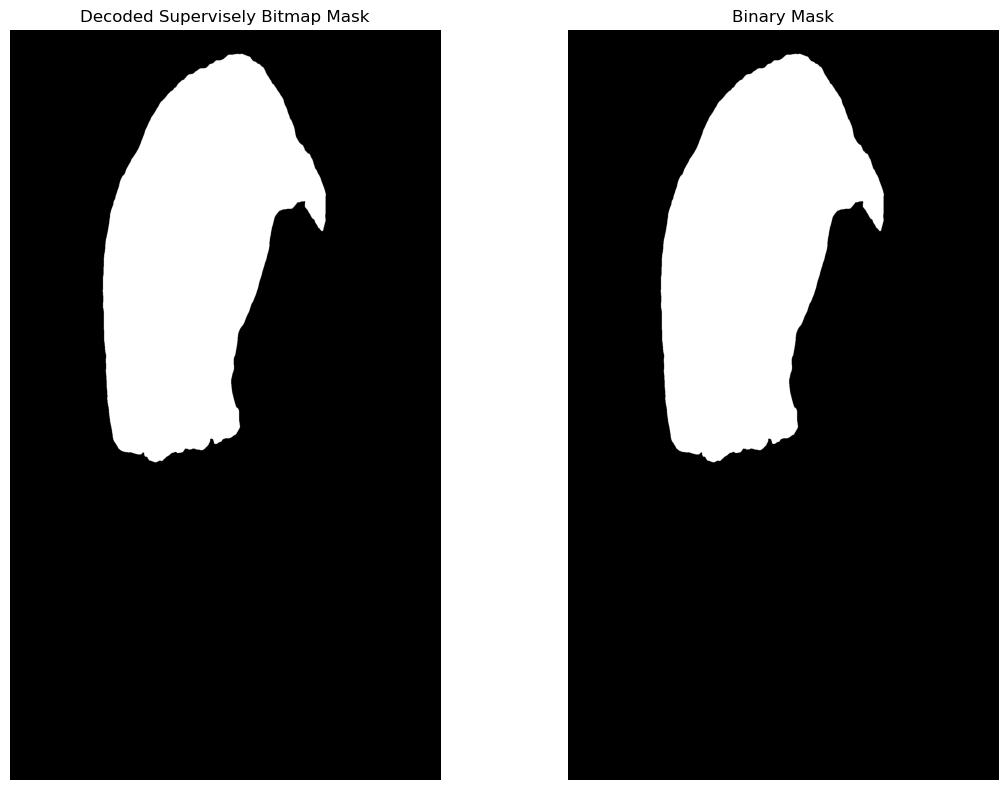

In [13]:
# Load and decode the annotation
json_path = r"supervisely/dataset/ann/IMG_0366.jpeg.json"
with open(json_path, 'r') as f:
    annotation_data = json.load(f)

print("Annotation info:")
print(f"Image size: {annotation_data['size']}")
print(f"Number of objects: {len(annotation_data.get('objects', []))}")

# Decode the bitmap mask
mask2 = decode_supervisely_bitmap_proper(annotation_data)

print(f"\nFinal mask shape: {mask2.shape}")
print(f"Final mask unique values: {np.unique(mask2)}")
print(f"Non-zero pixels: {np.sum(mask2 > 0)}")

# Visualize the mask
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(mask2, cmap='gray')
plt.title('Decoded Supervisely Bitmap Mask')
plt.axis('off')

# Show mask as binary
plt.subplot(1, 2, 2)
binary_mask2 = (mask2 > 0).astype(np.uint8)
plt.imshow(binary_mask2, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def measure_pig_length_and_widths(binary_mask, frac_shift=0.1, window_frac=0.1, visualize=True):
    """
    Measure the pig's main body length and approximate widths near the top and bottom
    based on PCA of the largest contour in a binary mask.

    Arg:
    binary_mask : np.ndarray
        Binary image (0 or 1 / 0 or 255) containing the pig segmentation.
    frac_shift : float
        Fraction of the length along the pig to measure the top/bottom width (default 0.1 = 10%).
    window_frac : float
        Fraction of the pig's length used to compute local width window (default 0.1 = 10%).
    visualize : bool
        Whether to display the annotated image.

    Returns:
    results : dict
        {
            "length": float,
            "width_top": float,
            "width_bottom": float,
            "annotated_image": np.ndarray
        }
    """
    # Ensure binary mask is uint8
    mask = (binary_mask > 0).astype(np.uint8)

    # Find largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the binary mask.")
    pig_contour = max(contours, key=cv2.contourArea)
    points = pig_contour.reshape(-1, 2).astype(np.float32)

    # PCA
    mean, eigenvectors = cv2.PCACompute(points, mean=np.array([]))
    center = mean[0]
    axis = eigenvectors[0] / np.linalg.norm(eigenvectors[0])  # main axis
    axis2 = eigenvectors[1] / np.linalg.norm(eigenvectors[1])  # perpendicular axis

    # Project points onto main axis to get endpoints
    proj = (points - center) @ axis
    min_proj, max_proj = proj.min(), proj.max()
    p1 = center + axis * min_proj
    p2 = center + axis * max_proj

    # Compute top/bottom sample points
    top_point = p1 + (p2 - p1) * frac_shift
    bottom_point = p2 - (p2 - p1) * frac_shift

    def local_width(sample_point, points, axis, axis2, window_frac):
        """Compute width along axis2 near sample_point."""
        length = np.linalg.norm(p2 - p1)
        window = length * window_frac

        proj_main = (points - sample_point) @ axis
        local_pts = points[np.abs(proj_main) <= window]

        if len(local_pts) < 2:
            return 0, sample_point, sample_point

        proj_perp = (local_pts - sample_point) @ axis2
        min_p, max_p = proj_perp.min(), proj_perp.max()
        p_start = sample_point + axis2 * min_p
        p_end = sample_point + axis2 * max_p
        width = np.linalg.norm(p_end - p_start)
        return width, p_start, p_end

    # Compute widths
    width_top, top_a, top_b = local_width(top_point, points, axis, axis2, window_frac)
    width_bottom, bot_a, bot_b = local_width(bottom_point, points, axis, axis2, window_frac)

    # Compute length
    length = np.linalg.norm(p2 - p1)

    # Draw visualization
    mask_rgb = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(mask_rgb, [pig_contour], -1, (0, 255, 0), 1)
    cv2.line(mask_rgb, tuple(p1.astype(int)), tuple(p2.astype(int)), (0, 0, 255), 2)  # main length
    cv2.line(mask_rgb, tuple(top_a.astype(int)), tuple(top_b.astype(int)), (255, 0, 0), 2)  # top width
    cv2.line(mask_rgb, tuple(bot_a.astype(int)), tuple(bot_b.astype(int)), (0, 165, 255), 2)  # bottom width

    if visualize:
        plt.imshow(cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB))
        plt.title("Pig Length and Local Widths")
        plt.axis("off")
        plt.show()

    return {
        "length": length,
        "width_top": width_top,
        "width_bottom": width_bottom,
        "annotated_image": mask_rgb
    }


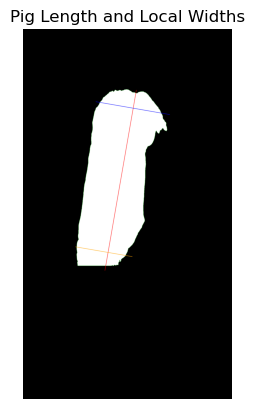

Pig length (pixels): 1438.66
Width near top: 588.73
Width near bottom: 453.20


In [17]:
results = measure_pig_length_and_widths(binary_mask)

print(f"Pig length (pixels): {results['length']:.2f}")
print(f"Width near top: {results['width_top']:.2f}")
print(f"Width near bottom: {results['width_bottom']:.2f}")


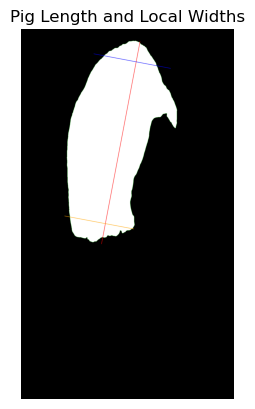

Pig length (pixels): 1473.17
Width near top: 557.78
Width near bottom: 501.79


In [ ]:
results = measure_pig_length_and_widths(binary_mask2)

print(f"Pig length (pixels): {results['length']:.2f}")
print(f"Width near top: {results['width_top']:.2f}")
print(f"Width near bottom: {results['width_bottom']:.2f}")
